In [1]:
%set_env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [158]:
import numpy as np
import pandas as pd
import os
import torch
import re
import string
import matplotlib.pyplot as plt
import torch.nn as nn
from termcolor import colored
from torch.utils.data import DataLoader
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from alibi.explainers.similarity.grad import GradientSimilarity

In [156]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y].astype('float32')

class TorchDataset(torch.utils.data.Dataset):
    """Utility class to create a torch dataloader from numpy arrays.
    """
    def __init__(self, *indexables):
        self.indexables = indexables

    def __getitem__(self, idx):
        output = tuple(indexable[idx] for indexable in self.indexables)
        return output if len(output) > 1 else output[0]

    def __len__(self):
        return len(self.indexables[0])
    
def clean_header(text):
    text = re.sub(r'(From:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Subject:[^\n]+\n)', '', text)
    text = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', text)
    text = re.sub(r'(Last-modified:[^\n]+\n)', '', text)
    text = re.sub(r'(Version:[^\n]+\n)', '', text)

    return text

def clean_text(text):        
    text = text.lower()
    text = text.strip()
    text = re.sub(re_url, '', text)
    text = re.sub(re_email, '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'(\d+)', ' ', text)
    text = re.sub(r'(\s+)', ' ', text)
    
    return text


## Load data

Loading and preparing the 20 news group data set.

In [201]:
re_url = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
re_email = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"' + 
                      '(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")' + 
                      '@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9]' + 
                      '(?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.)' + 
                      '{3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:' + 
                      '(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')

print("Loading 20 news groups dataset \n ")
data = fetch_20newsgroups(shuffle=True, random_state=1, subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          return_X_y=False)
X, y = np.asarray(data.data), data.target
target_names = data.target_names
df = pd.DataFrame({'text': X, 'labels': y})

print("Cleaning text \n ")
df['text_cleaned'] = df['text'].apply(clean_header)
df['text_cleaned'] = df['text_cleaned'].apply(clean_text)
print(colored("Sample document before cleaning \n==========================================", 'red'))
print(f"{df['text'][4]}")
print(colored("Sample document after cleaning \n==========================================", 'red'))
print(f"{df['text_cleaned'][4]}")
print('')
print("Splitting train - test")
df_train, df_test = train_test_split(df, test_size=0.2)
X_train, y_train = df_train['text_cleaned'].values, df_train['labels'].values
X_test, y_test = df_test['text_cleaned'].values, df_test['labels'].values
y_train, y_test = to_categorical(y_train, num_classes=20), to_categorical(y_test, num_classes=20)
print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

Loading 20 news groups dataset 
 
Cleaning text 
 
Sample document before cleaning 

So its an automatic? Don't know if US spec=CDN spec. for Maximas.


If it is the first set of brake pads on front, then this is fine. My car
eats a set every 15k miles or so. The fact that he is replacing the
muffler too is also ok.


The mileage is fairly low - but typical fwd stuff is CV joints. Check
the maintenance records with the manufacturers requirements for valve
adjustments, timing belt changes and so on.

The 60k mile service is often expensive, so make sure he has done everything.


Well, this is one of the commonly cited methods for identifying a
car with highway miles. 
Might check the gas pedal wear too. Ask him how many sets of tires he
has been through. A highway car might have squeezed by on 2 sets,
a hard driven car 6-10 sets.



Well, the Maxima should be pretty reliable - but if its out of warranty
you should get it checked out by someone knowledgeable first. Stuff
for Japanese car

## Define and train model

We define and train a pytorch classifier using sentence embeddings as inputs

In [36]:
load_20ng_model = False
save_model = False

### Define model

In [37]:
class EmbeddingModel:
    """Pre-trained sentence transformer wrapper.
    """
    def __init__(
        self,
        model_name: str = 'paraphrase-MiniLM-L6-v2',  # https://www.sbert.net/docs/pretrained_models.html
        max_seq_length: int = 200,
        batch_size: int = 32,
        device: torch.device = None
    ) -> None:
        if not isinstance(device, torch.device):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encode_text = SentenceTransformer(model_name).to(device)
        self.encode_text.max_seq_length = max_seq_length
        self.batch_size = batch_size
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.encode_text.encode(x, 
                                       convert_to_numpy=True, 
                                       batch_size=self.batch_size,
                                       show_progress_bar=False)

class Classifier(nn.Module):
    """FFNN classifier with pretrained sentence embeddings inputs.
    """
    def __init__(
        self, 
        n_classes= 20
    ) -> None:
        """ Text classification model from sentence embeddings. """
        super().__init__()
        self.head = nn.Sequential(nn.Linear(384, 256), 
                                  nn.LeakyReLU(.1), 
                                  nn.Dropout(.5), 
                                  nn.Linear(256, n_classes))
        
    def forward(self, sentence_embeddings) -> torch.Tensor:
        return self.head(sentence_embeddings)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

### Get sentence embeddings and define dataloaders

In [93]:
embedding_model = EmbeddingModel(device=device)

print('Getting train embeddings')    
embeddings_train = embedding_model(X_train)
train_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_train).to(device), 
                                       torch.Tensor(y_train).to(device)), 
                          batch_size=32, 
                          shuffle=True)

print('Getting test embeddings')  
embeddings_test = embedding_model(X_test)
test_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_test).to(device), 
                                      torch.Tensor(y_test).to(device)), 
                         batch_size=32, 
                         shuffle=False)

Getting train embeddings
Getting test embeddings


### Train model

In [94]:
filepath = './model_20ng/'  # change to directory where model is saved

if load_20ng_model:
    pass

else:
    epochs = 3
    # initialize classifier
    model = Classifier().to(device)
    print('training classifier')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        for x, y in tqdm(train_loader):
            y_hat = model(x)
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

    if save_model:
        pass

training classifier


100%|███████████████| 472/472 [00:00<00:00, 1122.05it/s]


### Evaluate model

In [103]:
def eval_model(model, loader):
    model.eval()
    logits, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            y_hat = model(x)
            logits += [y_hat.cpu().numpy()]
            labels += [y.cpu().numpy()]
    logits = np.concatenate(logits, 0)
    preds = np.argmax(logits, 1)
    labels = np.concatenate(labels, 0)
    accuracy = (preds == labels.argmax(axis=1)).mean()
    print(f'Accuracy: {accuracy:.3f}')
    
print('Train set evaluation')
eval_model(model, train_loader)
print('Test set evaluation')
eval_model(model, test_loader)

Train set evaluation
Accuracy: 0.700
Test set evaluation
Accuracy: 0.659


## Find similaraties 

Selecting a reference set of 1000 random samples from the training set. The `GradientSimilarity` explainer will find the most similar instances among those. This downsampling step is performed in order to speed up the `fit` step.

In [105]:
idxs_ref = np.random.choice(len(X_train), 1000, replace=False)
X_ref = X_train[idxs_ref]
embeddings_ref = embeddings_train[idxs_ref]
y_ref = y_train[idxs_ref]

Initializing a `GradientSimilarity` explainer instance

In [106]:
gsm = GradientSimilarity(model, 
                         loss_fn, 
                         precompute_grads=True, 
                         sim_fn='grad_cos', 
                         backend='pytorch', 
                         device=device)

Fitting the explainer on the reference data

In [107]:
gsm.fit(embeddings_ref, y_ref)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'pytorch',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random instances from the test set

In [108]:
idxs_samples = np.random.choice(len(X_test), 5, replace=False)
X_sample, embeddings_sample, y_sample = X_test[idxs_samples], embeddings_test[idxs_samples], y_test[idxs_samples]

Getting predictions and explanations for the each of the 5 test samples

In [110]:
preds = model(torch.Tensor(embeddings_sample).to(device)).detach().cpu().numpy().argmax(axis=1)
expls = gsm.explain(embeddings_sample, y_sample)

Building a dictionary for each sample for visualization purposes. 
Each dictionary contains
* The original text document `x` (not the embedding representation).
* The corresponding label `y`.
* The corresponding model's prediction `pred`.
* The reference instances ordered by similarity `x_sim`.
* The corresponding reference labels ordered by similarity `y_sim`.
* The corresponding model's predictions for the reference set `preds_sim`.

In [116]:
ds = []
for j in range(len(embeddings_sample)):
    y_sim = y_ref[expls.data['ordered_indices'][j]].argmax(axis=1)
    X_sim = X_ref[expls.data['ordered_indices'][j]]
    sim_embedding = embeddings_ref[expls.data['ordered_indices'][j]]
    preds_sim = model(torch.Tensor(sim_embedding).to(device)).detach().cpu().numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j],
         'x_sim': X_sim,
         'y_sim': y_sim, 
         'preds_sim': preds_sim}
    ds.append(d)

Showing the most similar instance for each of the test instances.

In [215]:
for sample_nb in range(5):
    print(colored(f"Sample nb {sample_nb}", 'blue'))
    print(colored("=================================================================================", 'blue'))
    print('')
    
    print(colored("Original instance - ", 'red'), 
          colored(f"Label: {target_names[ds[sample_nb]['y']]} - ", 'red'), 
          colored(f"Prediction: {target_names[ds[sample_nb]['pred']]}", 'red'))
    print(f"{ds[sample_nb]['x']}")
    print('')

    print(colored("Most similar instance - ", 'red'), 
          colored(f"Label: {target_names[ds[sample_nb]['y_sim'][0]]} - ", 'red'), 
          colored(f"Prediction: {target_names[ds[sample_nb]['preds_sim'][0]]}", 'red'))
    print(f"{ds[sample_nb]['x_sim'][0]}")
    print('')

Sample nb 0

Original instance -  Label: comp.graphics -  Prediction: comp.graphics
has anybody made a converter from irits irt or dat format to pov format thanks

Most similar instance -  Label: comp.graphics -  Prediction: comp.graphics
a shareware graphics program called pman has a filter that makes a picture look like a hand drawing this picture could probably be converted into vector format much easier because it is all lines with corel trace etc

Sample nb 1

Original instance -  Label: sci.med -  Prediction: sci.med
 i just wanted to point out that some of the food particularly the soups are prepared in a big batch so the restaurant wont be able to take the msg out of it sometimes its pretty hard to find out if this is the case or not

Most similar instance -  Label: sci.med -  Prediction: sci.med
no thats not how it works this may be through a different mechanism tenderizing beef involves sprinking or marinading it in papain an enzyme meat tenderizer packets might contain papai

## Most similar labels distributions 

In [ ]:
def plot_distributions(ds, expls, figsize=(20, 5)):

    for i in range(len(ds)):
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=False)
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': expls.data['scores'][i]})
        print(colored(f"Sample nb {i}", 'blue'))
        print(colored("=================================================================================", 'blue'))
        print('')

        print(colored("Original instance", 'red'))
        print(colored(f"Label: section {d['y']}, {target_names[d['y']]} - ", 'red'), 
              colored(f"Prediction: section {d['pred']},{target_names[d['pred']]}", 'red'))
        print('')
        print(f"{d['x']}")
        
              
        #print(f"Original instance, sample nb {i} \n " + 
        #      "========================================================================== \n " +
        #      f"{d['x']} \n " + 
        #      "========================================================================== \n " +
        #      f"Label: section {d['y']}, {target_names[d['y']]} \n " + 
        #      f"Prediction: section {d['pred']}, {target_names[d['pred']]} ")

        df_y = df_ditribution.groupby('y_sim')['scores'].mean().sort_values(ascending=False)
        df_y.plot(kind='bar', ax=axes[0])
        axes[0].set_title("Averaged scores for each true class in reference set \n")
        df_preds = df_ditribution.groupby('preds_sim')['scores'].mean().sort_values(ascending=False)
        df_preds.plot(kind='bar', ax=axes[1])
        axes[1].set_title("Averaged scores for each predicted class in reference set \n")

        plt.show()

In [ ]:
plot_distributions(ds, expls)

# Try to display text in a different way below

In [197]:
def print_side_by_side(a, b, size=40, space=4):
    while a or b:
        print(a[:size].ljust(size) + " " * space + b[:size])
        a = a[size:]
        b = b[size:]

In [200]:
title_orig = f"Original instance " 
title_sim = f"Most similar instance "
print_side_by_side(title_orig + ds[sample_nb]['x'], title_sim + ds[sample_nb]['x_sim'][0])

Original instance the harvard computer s    Most similar instance university of toro
ociety is pleased to announce its third     nto instructional and research computing
lecture of the spring ivan sutherland th     is sponsoring a technical presentation 
e father of computer graphics and an inn    on visualization software advance
ovator in microprocessing will be speaki    d visual systems avs s
ng at harvard university on tuesday apri    oftware pm pm thursday may sandfo
l at pm in aiken computations building r    rd fleming building room advanced visual
oom the title of his talk is logical eff     systems will present this technical sem
ort and the conflict over the control of    inar on avs the worlds leading visualiza
 information cookies and tea will be ser    tion software package avs is a point and
ved at pm in the aiken lobby admissions      click module driven easytouse product t
is free and all are welcome aiken is loc    hat produces full col

In [154]:
from io import BytesIO
from matplotlib.transforms import IdentityTransform
from matplotlib.figure import Figure

def text_to_rgba(s, *, dpi, fontsize=8):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none")
    fig.text(0, 0, s, fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

def appendInt(num):
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'

def plot_similar(ds, expls, nb_samples_to_display=2, figsize=(20, 10)):
    fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=False)
    #range_j = len(ds)
    range_j = 2
    for j in range(range_j):
        d = ds[j]
        orig_j = text_to_rgba(d['x'], fontsize=8, dpi=200)
        axes[j, 0].imshow(orig_j)
        if j == 0:
            axes[j, 0].set_title("Original instance \n" + 
                                 "================ \n " + 
                                 f"Label: section {d['y']}, {target_names[d['y']]} \n " + 
                                 f"Prediction: section {d['pred']}, {target_names[d['pred']]} ")
        else:
            axes[j, 0].set_title(f"Label: section {d['y']}, {target_names[d['y']]} \n " + 
                                 f"Prediction: section {d['pred']}, {target_names[d['pred']]} ")
        #range_i = len(d['expl'].data['most_similar'])
        if nb_samples_to_display > len(expls.data['most_similar'][j]):
            nb_samples_to_display = len(expls.data['most_similar'][j])
        
                                        
        for i in range(nb_samples_to_display):
            sim_ji = text_to_rgba(d['x_sim'][i], fontsize=30, dpi=200)
            axes[j, i + 1].imshow(sim_ji)
            if j == 0:
                axes[j, i + 1].set_title(f"{i+1}{appendInt(i+1)} most similar instance \n" + 
                                         "================ \n " + 
                                         f"Label: section {d['y_sim'][i]}, {target_names[d['y_sim'][i]]} \n " + 
                                         f"Prediction: section {d['preds_sim'][i]}, {target_names[d['preds_sim'][i]]}")
            else:
                axes[j, i + 1].set_title(f"Label: section {d['y_sim'][i]}, {target_names[d['y_sim'][i]]} \n " + 
                                         f"Prediction: section {d['preds_sim'][i]}, {target_names[d['preds_sim'][i]]}")
    plt.show()

def plot_distributions(ds, expls, figsize=(20, 5)):

    for i in range(len(ds)):
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=False)
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': expls.data['scores'][i]})
        
        # rgba = text_to_rgba(d['x'], fontsize=8, dpi=100)
        # axes[i, 0].imshow(rgba)
        
        
        print(f"Original instance, sample nb {i} \n " + 
              "========================================================================== \n " +
              f"{d['x']} \n " + 
              "========================================================================== \n " +
              f"Label: section {d['y']}, {target_names[d['y']]} \n " + 
              f"Prediction: section {d['pred']}, {target_names[d['pred']]} ")
            #axes[i, 0].set_title("Original instance \n " + 
            #                     "=================== \n " + 
            #                     f"Label: section {d['y']}, {target_names[d['y']]} \n " + 
            #                     f"Prediction: section {d['pred']}, {target_names[d['pred']]} ")
            #print(f"============================================================================== \n")

        df_y = df_ditribution.groupby('y_sim')['scores'].mean().sort_values(ascending=False)
        df_y.plot(kind='bar', ax=axes[0])
        axes[0].set_title("Averaged scores for each true class in reference set \n" + 
                                 "================================== \n ")
        df_preds = df_ditribution.groupby('preds_sim')['scores'].mean().sort_values(ascending=False)
        df_preds.plot(kind='bar', ax=axes[1])
        axes[1].set_title("Averaged scores for each predicted class in reference set \n" + 
                                 "================================== \n ")

        plt.show()



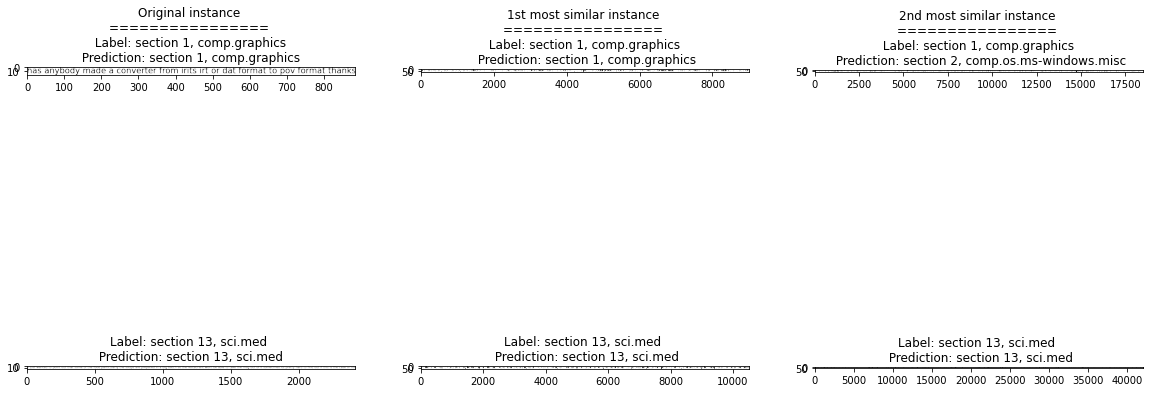

In [138]:
plot_similar(ds, expls)

In [50]:
ds[3]['x']

'excellent discussion of dc landing techniques by henry deleted the dc will not take of horizontally it takes of vertically for several reasons vertical landings require miles of runway and limit noise pollution they require wheels or wings just turn on the engines and touch down of course as henry pointed out vetical landings quite that simple well to be blunt yes but at least learning the soyuz vehicles use parachutes for the descent and then fire small rockets just before they hit the ground parachutes are however not especially practical if you want to reuse something without much effort the landings are also not very comfortable however in the words of georgy grechko prefer to have bruises not to sink'

In [51]:
ds[3]['x_sim'][0][0]

'how hard or easy would it be to have combo mission such as solar sail on the way out to the outer planets but once in near to orbit to use more normal means seems that everyone talks about using one system and one system only per mission why not have more than one propulsion system or did miss something or did it die in committee michael adams nsmca alaska edu not high just jacked'

-----------